In [1]:
import numpy as np
from torch_geometric.utils.convert import from_networkx
from sklearn.model_selection import train_test_split
import networkx as nx 
import matplotlib.pyplot as plt

import extractingHG as exHG

In [2]:
# Extracting the information...

# exHG.extracting_patient_visit_labels()

# Reading everything...
Patients    = exHG.reading_pickle('Data/symmetricPath/patients.pickle')
Visits      = exHG.reading_pickle('Data/symmetricPath/visits.pickle')
Medications = exHG.reading_pickle('Data/symmetricPath/medication.pickle')
Diagnosis   = exHG.reading_pickle('Data/symmetricPath/diagnosis.pickle')
Procedures  = exHG.reading_pickle('Data/symmetricPath/procedures.pickle')

# Reading the metapath (pathsim-based) overall similarity matrix
data        = exHG.reading_pickle('Data/symmetricPath/data_B.pickle')

# Reading the labels
Patients_label = exHG.reading_pickle('Data/labels/patient_labels.pickle')
Visits_label   = exHG.reading_pickle('Data/labels/visit_labels.pickle')

In [3]:
data

array([[2., 1., 1., ..., 0., 0., 0.],
       [1., 2., 1., ..., 0., 0., 0.],
       [1., 1., 2., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 3., 2., 2.],
       [0., 0., 0., ..., 2., 3., 2.],
       [0., 0., 0., ..., 2., 2., 3.]])

In [4]:
selected_length = 30
Diagnosis_List = []
for patient in Patients:
    Diagnosis_List.append(Patients_label[patient])
print(type(Diagnosis_List[0]))
total_diagnosis = sum([d for d in Diagnosis_List])
Diagnosis_freq = {Diagnosis[i]: total_diagnosis[i] for i in range(len(total_diagnosis))}
sorted_Diagnosis_freq = sorted(Diagnosis_freq.items(), key=lambda x: x[1], reverse=True)

top_diagnosis = sorted_Diagnosis_freq[:selected_length]
top_dict = dict(top_diagnosis)
print(f'Top {selected_length} Items:', top_dict)

selected_cols = [i for i, v in enumerate(Diagnosis) if v in top_dict]
new_label = [arr[selected_cols] for arr in Diagnosis_List]
Patients_label2 = {patient: new_label[i] for i, patient in enumerate(Patients)}

<class 'numpy.ndarray'>
Top 30 Items: {'D_162.0': 998, 'D_401.0': 396, 'D_518.0': 392, 'D_198.0': 371, 'D_427.0': 340, 'D_272.0': 272, 'D_276.0': 243, 'D_496.0': 217, 'D_285.0': 205, 'D_V15': 200, 'D_486.0': 195, 'D_197.0': 180, 'D_250.0': 178, 'D_584.0': 173, 'D_414.0': 163, 'D_428.0': 153, 'D_530.0': 152, 'D_V10': 151, 'D_196.0': 150, 'D_V45': 140, 'D_511.0': 130, 'D_458.0': 105, 'D_305.0': 105, 'D_E87': 99, 'D_E93': 92, 'D_V58': 87, 'D_244.0': 87, 'D_38.0': 85, 'D_785.0': 85, 'D_585.0': 83}


In [5]:
new_freq = [top_dict[t] for t in top_dict]
print('average number of diagnosis on selected set is ', sum(new_freq)/len(new_freq) )

average number of diagnosis on selected set is  207.56666666666666


In [6]:
import torch

# Setting the graph based on the similarity matrix
G = nx.Graph()

Nodes = Patients + Visits + Medications + Diagnosis  + Procedures
G.add_nodes_from(Nodes)

# assign the Patient label as Y...
for node in G.nodes:
    if node[0]=='C':
        G.nodes[node]['y'] = torch.tensor(Patients_label2[node])
    else:
        G.nodes[node]['y'] = torch.tensor(np.zeros((selected_length)))

# assign the weight of the edges into the graph
for i, v in enumerate(Nodes):
    if v[0]!= 'D':
        for j, u in enumerate(Nodes):
            if data[i][j]>0 and u[0]!='D':
                G.add_edge(v, u, weight=data[i][j])

# Nodes features
# X = np.random.randn(len(list(G.nodes())), 128)
X = np.eye(len(list(G.nodes())))

for i, node in enumerate(list(G.nodes())):
    G.nodes[node]['x'] = X[i]

In [7]:
# Creating the data structure
data = from_networkx(G)

c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  data[key] = torch.tensor(value)


In [8]:
print(data)

newY = []
total = 0

# extracting the *Patients* nodes and their *indexes* for the learning process.
for i,v in enumerate(Nodes):
    if v[0]=='C':
        newY.append([i,data.y[i]])
        total+=1

Data(x=[2821, 2821], edge_index=[2, 2418040], y=[2821, 30], weight=[2418040])


In [9]:
y_train, y_left = train_test_split(newY    , train_size=0.7, random_state=42)
y_val,   y_test = train_test_split(y_left  , test_size=2/3, random_state=42)

# Create masks for train, validation, and test sets
train_mask = np.zeros(len(data.y), dtype=bool)
val_mask = np.zeros(len(data.y), dtype=bool)
test_mask = np.zeros(len(data.y), dtype=bool)

for i,v in y_train:
    train_mask[i] = True

for i,v in y_val:
    val_mask[i] = True

for i, v in y_test:
    test_mask[i] = True

print(train_mask.shape)
print(val_mask.shape)
print(test_mask.shape)

print('Train = ', sum([1 if v else 0 for v in train_mask])/total)
print('Val = ', sum([1 if v else 0 for v in val_mask])/total)
print('Test = ', sum([1 if v else 0 for v in test_mask])/total)

(2821,)
(2821,)
(2821,)
Train =  0.6993987975951904
Val =  0.10020040080160321
Test =  0.20040080160320642


In [10]:
data.train_mask = train_mask
data.test_mask  = test_mask
data.val_mask   = val_mask

In [11]:
data.y[0]

tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

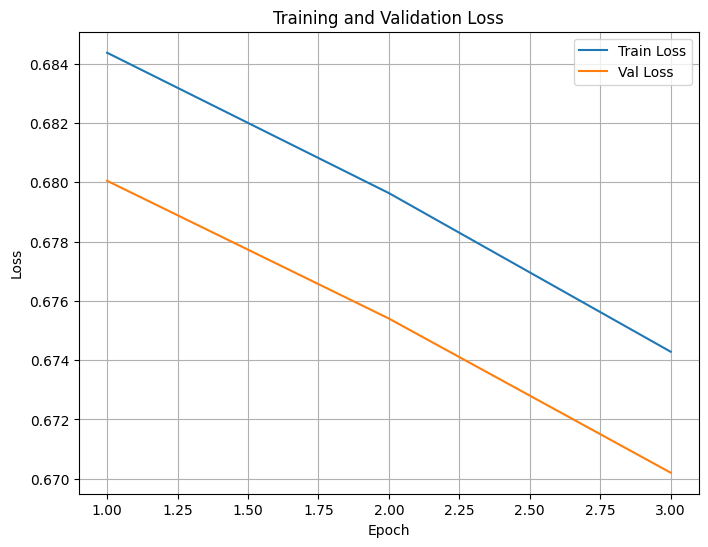

In [12]:
import GNN_multilabel as GNNM
import torch
import torch.nn.functional as F

data.x = data.x.float()
# data.y = data.y
num_classes = selected_length

# Check if a GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = data.to(device)
gcn = GNNM.SAGE_MLC(data.num_node_features, num_classes).to(device)

optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
# criterion = torch.nn.CrossEntropyLoss()
# criterion = F.binary_cross_entropy_with_logits
criterion = torch.nn.BCEWithLogitsLoss()
gcn, df = GNNM.train_node_classifier(gcn, data, optimizer_gcn, criterion, n_epochs=3)

GNNM.plt_performance(df)

In [13]:
# ----------------------------------------------------------------------------
pred = gcn(data) #.argmax(dim=1)
pred    = pred  [data.test_mask].detach().cpu().numpy()
correct = data.y[data.test_mask].detach().cpu().numpy()

# print(pred.shape)
# print(correct.shape)

correct_binary = (correct > 0).astype(int)
pred_binary = (pred > 0).astype(int)

# GNNM.create_confusion_matrix(pred, correct)
GNNM.create_multilabel_confusion_matrix(pred_binary, correct_binary)

# test_acc, _ = GNNM.eval_node_classifier(gcn, data, data.test_mask)
# print(f'Test Acc: {test_acc:.3f}\n')

              precision    recall  f1-score   support

           0       0.35      1.00      0.52        70
           1       1.00      1.00      1.00       200
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        59
           5       0.00      0.00      0.00        81
           6       0.19      1.00      0.32        38
           7       0.00      0.00      0.00        32
           8       0.00      0.00      0.00        70
           9       0.17      1.00      0.30        35
          10       0.00      0.00      0.00        30
          11       0.00      0.00      0.00        78
          12       0.00      0.00      0.00        19
          13       0.22      1.00      0.36        44
          14       0.00      0.00      0.00        28
          15       0.00      0.00      0.00        18
          16       0.08      0.76      0.14        17
          17       0.00    

c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
from sklearn.metrics import f1_score
print('F1- score : ', sum([f1_score(correct_binary[i], pred_binary[i], average='macro', zero_division=0) for i in range(len(correct_binary))])/len(correct_binary))

F1- score :  0.5271955224729458
